In [1]:
import pandas as pd
import gmaps as gp
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

TAM_IMG=(12,8) #Tamaño de las imagenes

In [2]:
properati = pd.read_csv('datos/properati_2.csv')
len(properati)

121220

In [3]:
properati.dtypes

created_on                  object
operation                   object
property_type               object
place_name                  object
place_with_parent_names     object
country_name                object
state_name                  object
geonames_id                float64
lat                        float64
lon                        float64
price                      float64
currency                    object
precio_aprox_local         float64
precio_aprox_usd           float64
surface_total_in_m2        float64
surface_covered_in_m2      float64
precio_usd_por_m2          float64
precio_por_m2              float64
floor                      float64
rooms                      float64
expenses                   float64
description                 object
region                      object
localidad                   object
ciudad                      object
barrio                      object
dtype: object

In [4]:
properati.loc[:,('created_on')] = pd.to_datetime(properati['created_on'])

In [5]:
#Saco algunas columnas que no parecen servir
properati_filtrado = properati.drop( ['description',
                            'country_name','state_name','place_name','geonames_id'], 1)
# los geonames hacen referencia a place_name y no a la propiedad
properati_filtrado.dropna(how='all',inplace=True)
properati_filtrado.drop('place_with_parent_names',1,inplace=True)
properati_filtrado

,created_on,operation,property_type,lat,lon,price,currency,precio_aprox_local,precio_aprox_usd,surface_total_in_m2,surface_covered_in_m2,precio_usd_por_m2,precio_por_m2,floor,rooms,expenses,region,localidad,ciudad,barrio
0,2017-02-01,sell,PH,-34.661824,-58.508839,62000.0,USD,1.093959e+06,62000.0,55.0,40.0,1127.0,19890.0,NaN,NaN,NaN,Capital Federal,Mataderos,NaN,NaN
1,2017-02-01,sell,apartment,-34.903883,-57.964330,150000.0,USD,2.646675e+06,150000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bs.As. G.B.A. Zona Sur,La Plata,NaN,NaN
2,2017-02-01,sell,apartment,-34.652262,-58.522982,72000.0,USD,1.270404e+06,72000.0,55.0,55.0,1309.0,23098.0,NaN,NaN,NaN,Capital Federal,Mataderos,NaN,NaN
3,2017-02-01,sell,PH,-34.647797,-58.516424,95000.0,USD,1.676228e+06,95000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Capital Federal,Liniers,NaN,NaN
4,2017-02-01,sell,apartment,-38.002626,-57.549447,64000.0,USD,1.129248e+06,64000.0,35.0,35.0,1828.0,32264.0,NaN,NaN,NaN,Buenos Aires Costa AtlÃ¡ntica,Mar del Plata,Centro,NaN
5,2017-02-01,sell,house,-33.014071,-58.519828,NaN,NaN,NaN,NaN,53.0,NaN,NaN,NaN,NaN,NaN,NaN,Entre RÃ­os,GualeguaychÃº,NaN,NaN
6,2017-02-01,sell,PH,-34.532957,-58.521782,130000.0,USD,2.293785e+06,130000.0,106.0,78.0,1226.0,21639.0,NaN,NaN,NaN,Bs.As. G.B.A. Zona Norte,Vicente LÃ³pez,Munro,NaN
7,2017-02-01,sell,apartment,-34.559873,-58.443362,138000.0,USD,2.434941e+06,138000.0,45.0,40.0,3066.0,54109.0,NaN,NaN,NaN,Capital Federal,Belgrano,NaN,NaN
8,2017-02-01,sell,apartment,-34.559873,-58.443362,195000.0,USD,3.440678e+06,195000.0,65.0,60.0,3000.0,52933.0,NaN,NaN,NaN,Capital Federal,Belgrano,NaN,NaN
9,2017-02-01,sell,house,-32.942031,-60.725919,460000.0,ARS,4.600000e+05,26070.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Santa Fe,Rosario,NaN,NaN


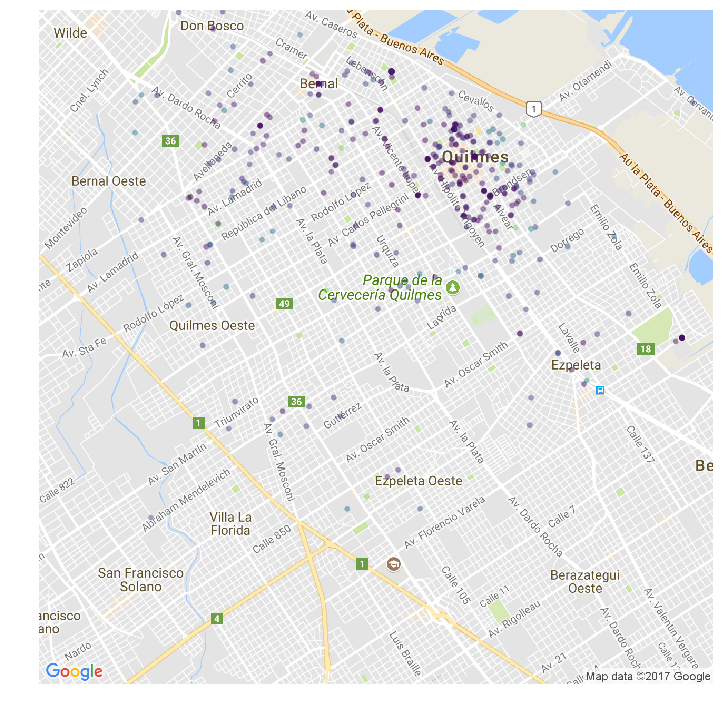

In [6]:
#solo para probar si funcionaba
cap=properati_filtrado.loc[properati_filtrado['localidad'] == 'Quilmes']
gp.scatter(cap['lat'], cap['lon'],cap['surface_total_in_m2'])

In [7]:
properati_filtrado = properati_filtrado.dropna(subset=['price'])  

In [8]:
properati_filtrado.sort_values('precio_por_m2',ascending = False).head(200)

,created_on,operation,property_type,lat,lon,price,currency,precio_aprox_local,precio_aprox_usd,surface_total_in_m2,surface_covered_in_m2,precio_usd_por_m2,precio_por_m2,floor,rooms,expenses,region,localidad,ciudad,barrio
26637,2017-04-28,sell,apartment,-34.622204,-58.416089,6809000.0,USD,1.201414e+08,6809000.0,33.0,33.0,206333.0,3640648.0,NaN,1.0,NaN,Capital Federal,Boedo,NaN,NaN
26037,2017-04-28,sell,apartment,NaN,NaN,5214782.0,USD,9.201222e+07,5214782.0,30.0,30.0,173826.0,3067074.0,NaN,1.0,NaN,Capital Federal,Boedo,NaN,NaN
26193,2017-04-28,sell,apartment,NaN,NaN,3657014.0,USD,6.452618e+07,3657014.0,35.0,35.0,104486.0,1843605.0,NaN,1.0,NaN,Capital Federal,Boedo,NaN,NaN
114131,2017-07-26,sell,house,-34.657171,-58.682625,12000000.0,USD,2.117340e+08,12000000.0,150.0,85.0,80000.0,1411560.0,NaN,NaN,NaN,Bs.As. G.B.A. Zona Oeste,ItuzaingÃ³,NaN,NaN
25853,2017-04-28,sell,apartment,NaN,NaN,2356000.0,USD,4.157044e+07,2356000.0,30.0,30.0,78533.0,1385681.0,NaN,1.0,NaN,Capital Federal,Boedo,NaN,NaN
44906,2017-06-09,sell,store,-32.940596,-60.665226,1434552.0,USD,2.531195e+07,1434552.0,25.0,25.0,57382.0,1012478.0,NaN,NaN,NaN,Santa Fe,Rosario,NaN,NaN
27066,2017-04-28,sell,apartment,NaN,NaN,2173330.0,USD,3.834732e+07,2173330.0,45.0,40.0,48296.0,852162.0,NaN,2.0,NaN,Bs.As. G.B.A. Zona Norte,General San MartÃ­n,Villa Ballester,NaN
27004,2017-04-28,sell,apartment,NaN,NaN,2173330.0,USD,3.834732e+07,2173330.0,45.0,40.0,48296.0,852162.0,NaN,2.0,NaN,Bs.As. G.B.A. Zona Norte,General San MartÃ­n,Villa Ballester,NaN
26992,2017-04-28,sell,apartment,NaN,NaN,2173330.0,USD,3.834732e+07,2173330.0,45.0,40.0,48296.0,852162.0,NaN,2.0,NaN,Bs.As. G.B.A. Zona Norte,General San MartÃ­n,Villa Ballester,NaN
27065,2017-04-28,sell,apartment,NaN,NaN,2099440.0,USD,3.704357e+07,2099440.0,46.0,42.0,45640.0,805294.0,NaN,2.0,NaN,Bs.As. G.B.A. Zona Norte,General San MartÃ­n,Villa Ballester,NaN


#### Filtro las propiedades cuyos precios tengan incoherencias

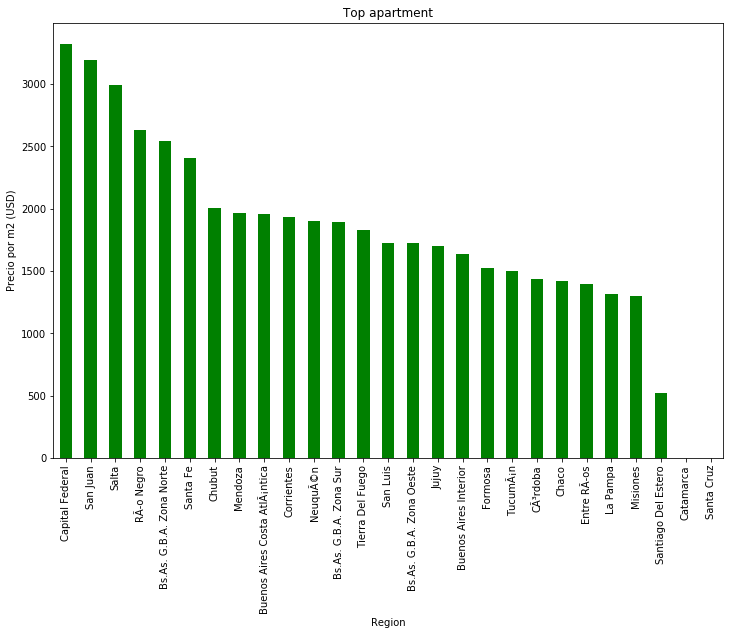

In [9]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='apartment'].groupby('region').mean()['precio_usd_por_m2'].sort_values(ascending=False)
ranking_precios_usd.plot(kind='bar',figsize=TAM_IMG,color='g')
plt.title('Top apartment')
plt.xlabel('Region')
plt.ylabel('Precio por m2 (USD)')
plt.show()

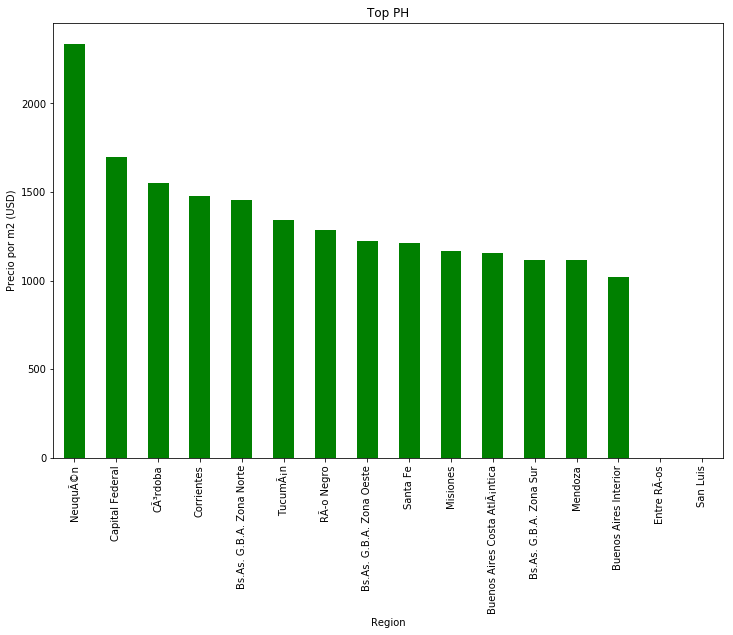

In [10]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='PH'].groupby('region').mean()['precio_usd_por_m2'].sort_values(ascending=False)
ranking_precios_usd.plot(kind='bar',figsize=TAM_IMG,color='g')
plt.title('Top PH')
plt.xlabel('Region')
plt.ylabel('Precio por m2 (USD)')
plt.show()

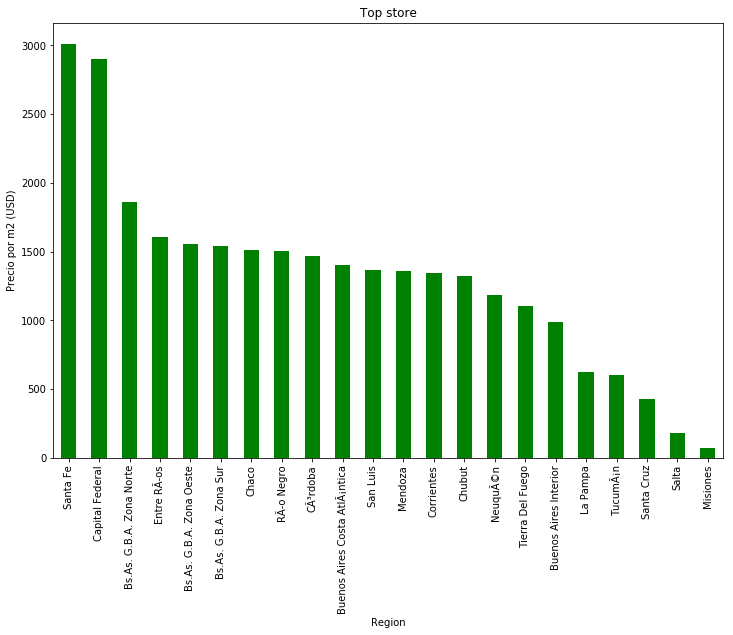

In [11]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='store'].groupby('region').mean()['precio_usd_por_m2'].sort_values(ascending=False)
ranking_precios_usd.plot(kind='bar',figsize=TAM_IMG,color='g')
plt.title('Top store')
plt.xlabel('Region')
plt.ylabel('Precio por m2 (USD)')
plt.show()

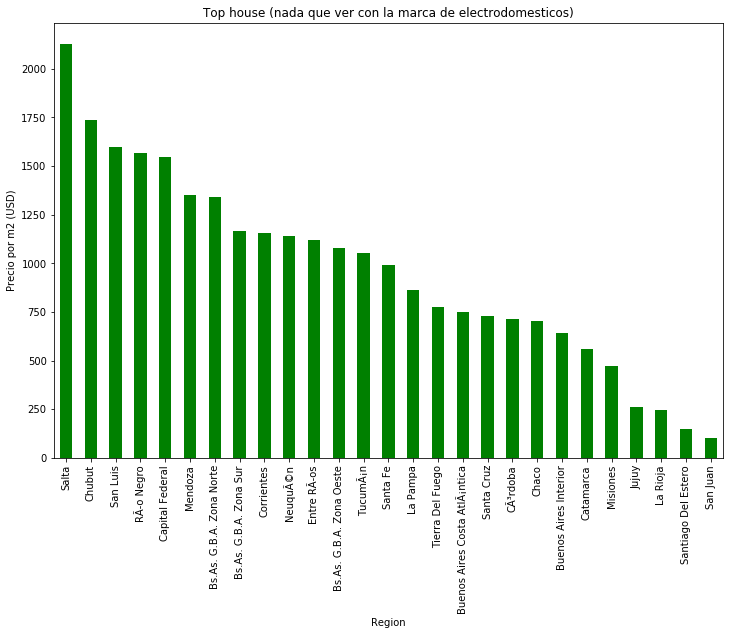

In [12]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='house'].groupby('region').mean()['precio_usd_por_m2'].sort_values(ascending=False)
ranking_precios_usd.plot(kind='bar',figsize=TAM_IMG,color='g')
plt.title('Top house (nada que ver con la marca de electrodomesticos)')
plt.xlabel('Region')
plt.ylabel('Precio por m2 (USD)')
plt.show()

In [13]:
propiedades_full=properati
propiedades_full.columns

Index([u'created_on', u'operation', u'property_type', u'place_name',
       u'place_with_parent_names', u'country_name', u'state_name',
       u'geonames_id', u'lat', u'lon', u'price', u'currency',
       u'precio_aprox_local', u'precio_aprox_usd', u'surface_total_in_m2',
       u'surface_covered_in_m2', u'precio_usd_por_m2', u'precio_por_m2',
       u'floor', u'rooms', u'expenses', u'description', u'region',
       u'localidad', u'ciudad', u'barrio'],
      dtype='object')

In [14]:
properties_by_type=propiedades_full[['place_name','property_type']]


In [15]:
properties_by_type_and_total=properties_by_type.groupby('place_name').count().reset_index()

In [16]:
properties_by_type_and_total.columns=['place_name','total_properties']
properties_by_type_and_total

,place_name,total_properties
0,Country Maschwitz Club,3
1,los alamos,1
2,9 de Abril,3
3,Abasto,139
4,Abril Club de Campo,19
5,Acacias Blancas,34
6,Acassuso,242
7,Achiras,8
8,Adolfo Alsina,8
9,AdroguÃ©,734


In [17]:
properties_by_type=properties_by_type.groupby('place_name').apply(lambda x: x['property_type'].value_counts()).reset_index()
properties_by_type=pd.pivot_table(properties_by_type,index=['place_name'],columns=['level_1']).reset_index()
properties_by_type

place_name property_type                   \
level_1                                                PH apartment  house   
0                    Country Maschwitz Club           NaN       NaN    3.0   
1                                los alamos           NaN       1.0    NaN   
2                                9 de Abril           NaN       NaN    1.0   
3                                    Abasto          14.0      79.0   37.0   
4                       Abril Club de Campo           NaN       NaN   19.0   
5                           Acacias Blancas           NaN       NaN   34.0   
6                                  Acassuso           8.0      88.0  138.0   
7                                   Achiras           NaN       4.0    3.0   
8                             Adolfo Alsina           NaN       NaN    8.0   
9                                  AdroguÃ©          25.0     172.0  503.0   
10          Aeropuerto Internacional Ezeiza           NaN       NaN    2.0   
11                               AgronomÃ­a           7.0      29.0    4.0   
12                              Agua Blanca           NaN       NaN    1.0   
13                              Agua de Oro           NaN       NaN    6.0   
14                             Aguas Verdes           2.0       8.0    5.0   
15                 Albanueva Barrio Cerrado           NaN      15.0   11.0   
16                          Aldea Brasilera           NaN       NaN    1.0   
17                              Aldea Salto           NaN       NaN    1.0   
18                               Aldo Bonzi           NaN       NaN    5.0   
19                           Alejandro Korn           NaN       1.0   14.0   
20                           Alejandro Roca           NaN       NaN    1.0   
21                                     Alem           NaN       2.0    NaN   
22                                    Alfar           NaN       NaN    1.0   
23                               Almafuerte           NaN       NaN    7.0   
24                                  Almagro          68.0    1023.0   38.0   
25                          Almirante Brown           2.0      13.0   26.0   
26                              Alta Gracia           NaN       3.0   15.0   
27                                 Altamira           NaN       NaN   14.0   
28                        Alto Los Cardales           NaN       NaN    3.0   
29                        Altos de Hudson I           NaN       NaN    1.0   
...                                     ...           ...       ...    ...   
1030              Villa Santa Cruz del Lago           NaN       1.0   10.0   
1031                       Villa Santa Rita          13.0      32.0   11.0   
1032                        Villa Sarmiento          20.0      78.0   53.0   
1033                          Villa Soldati           2.0       8.0    3.0   
1034                            Villa Tesei           NaN       2.0   12.0   
1035                          Villa Udaondo           1.0       1.0   23.0   
1036                           Villa UniÃ³n           NaN       1.0    NaN   
1037                          Villa Urquiza          92.0    1451.0   65.0   
1038                         Villa Vatteone           1.0       1.0    4.0   
1039                          Villa Ventana           NaN       NaN    1.0   
1040                     Villa de Las Rosas           NaN       NaN    4.0   
1041                          Villa de Mayo           NaN      10.0   25.0   
1042                          Villa de Soto           NaN       NaN    2.0   
1043                        Villa del Dique           NaN       NaN   23.0   
1044                       Villa del Parque          47.0     378.0   50.0   
1045                      Villa del Totoral           NaN       NaN    8.0   
1046     Village Golf & Tennis Country Club           NaN       NaN    7.0   
1047                                Villars           NaN       NaN    1.0   
1048                       Virasoro Village           N

In [18]:
 properties_by_type.columns=['place_name','PH','apartment','house','store']

In [19]:
properties_by_type_and_total=pd.merge(properties_by_type,properties_by_type_and_total,on = 'place_name', how='left')

In [20]:
properties_by_type_and_total_mean=properties_by_type_and_total

In [21]:
properties_by_type_and_total_mean=properties_by_type_and_total_mean.fillna(value=0)

In [22]:
properties_by_type_and_total_mean.loc[:,('apartment_percent')]=properties_by_type_and_total_mean['apartment']/properties_by_type_and_total_mean['total_properties']
properties_by_type_and_total_mean.loc[:,('PH_percent')]=properties_by_type_and_total_mean['PH']/properties_by_type_and_total_mean['total_properties']
properties_by_type_and_total_mean.loc[:,('house_percent')]=properties_by_type_and_total_mean['house']/properties_by_type_and_total_mean['total_properties']
properties_by_type_and_total_mean.loc[:,('store_percent')]=properties_by_type_and_total_mean['store']/properties_by_type_and_total_mean['total_properties']

In [23]:
properties_by_type_and_total_mean

,place_name,PH,apartment,house,store,total_properties,apartment_percent,PH_percent,house_percent,store_percent
0,Country Maschwitz Club,0.0,0.0,3.0,0.0,3,0.000000,0.000000,1.000000,0.000000
1,los alamos,0.0,1.0,0.0,0.0,1,1.000000,0.000000,0.000000,0.000000
2,9 de Abril,0.0,0.0,1.0,2.0,3,0.000000,0.000000,0.333333,0.666667
3,Abasto,14.0,79.0,37.0,9.0,139,0.568345,0.100719,0.266187,0.064748
4,Abril Club de Campo,0.0,0.0,19.0,0.0,19,0.000000,0.000000,1.000000,0.000000
5,Acacias Blancas,0.0,0.0,34.0,0.0,34,0.000000,0.000000,1.000000,0.000000
6,Acassuso,8.0,88.0,138.0,8.0,242,0.363636,0.033058,0.570248,0.033058
7,Achiras,0.0,4.0,3.0,1.0,8,0.500000,0.000000,0.375000,0.125000
8,Adolfo Alsina,0.0,0.0,8.0,0.0,8,0.000000,0.000000,1.000000,0.000000
9,AdroguÃ©,25.0,172.0,503.0,34.0,734,0.234332,0.034060,0.685286,0.046322


In [24]:
properties_by_usd_m2=propiedades_full[['place_name','precio_usd_por_m2']].dropna().groupby('place_name').mean().reset_index()

In [25]:
properties_by_m2_and_type_mean=pd.merge(properties_by_usd_m2,properties_by_type_and_total_mean,on='place_name',how='left')

In [26]:
properties_by_m2_and_type_mean_greater_than_20 = properties_by_m2_and_type_mean[properties_by_m2_and_type_mean['total_properties']>20]

In [27]:
properties_by_m2_and_type_mean_greater_than_20.loc[properties_by_m2_and_type_mean_greater_than_20['apartment_percent']< 0.5]['total_properties'].count()

216

## propiedades con patio y a estrenar

In [28]:
news_properties_with_garden=pd.DataFrame({'place_name':propiedades_full['place_name']\
                                          ,'description':propiedades_full['description'],'precio_usd_por_m2':propiedades_full['precio_usd_por_m2']})


In [29]:
news_properties_with_garden=news_properties_with_garden.dropna(how='any')

In [30]:
news_properties_with_garden.loc[:,'has_garden']=news_properties_with_garden.loc[:,'description'].str.lower().str.contains('patio')
news_properties_with_garden.loc[:,'is_new']=news_properties_with_garden.loc[:,'description'].str.lower().str.contains('estrenar')

In [31]:
news_properties_with_garden.sort_values(by='precio_usd_por_m2',ascending=False).loc[:10]

,description,place_name,precio_usd_por_m2,has_garden,is_new
26637,Departamento 1 ambiente divisible Depto en CU...,Boedo,206333.0,False,False
26037,lan840- DEPTO FINANCIACION DIRECTA EN PESOSAnt...,Boedo,173826.0,False,False
26193,fac030- Depto anticipo en 10 meses y saldo en ...,Boedo,104486.0,False,False
114131,"CODIGO: ubicado en: MONSEÃOR TERRERO , Ituza...",ItuzaingÃ³,80000.0,True,False
25853,bf221- INCREIBLE FORMA DE PAGO- ANT Y CUOTAS D...,Boedo,78533.0,False,False
44906,1119-AE035 Rosario: Av. Francia 735 (Entre Crd...,Rosario,57382.0,False,False
26992,EDIFICIO: GALA XVIII Venta en Cuotas y en Peso...,Villa Ballester,48296.0,False,False
27066,EDIFICIO: GALA XVIII Venta en Cuotas y en Peso...,Villa Ballester,48296.0,False,False
27004,EDIFICIO: GALA XVIII Venta en Cuotas y en Peso...,Villa Ballester,48296.0,False,False
27065,EDIFICIO: GALA XVIII Venta en Cuotas y en Peso...,Villa Ballester,45640.0,False,False


## Veamos cuales son las ciudades que vendieron más casas con patio

In [32]:
properties_total=propiedades_full[['place_name','property_type']]
#Calculo el total de las ventas por ciudad
properties_total=properties_total.groupby('place_name').count().reset_index()

In [33]:
properties_total.columns=['place_name','total']

In [34]:
#Calculo la cantidad de casas con jardines vendidas por ciudad
properties_garden_count=news_properties_with_garden[['place_name','has_garden']][news_properties_with_garden['has_garden']]\
.groupby('place_name').count().reset_index()

In [35]:
#Merge entre cantidad de casas con jardines con cantidad total de casas
properties_garden_count=pd.merge(properties_garden_count,properties_total,on='place_name',how='left')

In [36]:
properties_garden_count.loc[:,('has_garden_percent')]=properties_garden_count['has_garden']/properties_garden_count['total']

In [37]:
#Elimino los datos con menores a 50 ventas.
properties_garden_count=properties_garden_count[properties_garden_count['total']>50]

In [38]:
properties_garden_count.sort_values(by='has_garden_percent',ascending=False)

,place_name,has_garden,total,has_garden_percent
407,Tres Arroyos,36,80,0.450000
449,Villa Madero,21,54,0.388889
415,ValentÃ­n Alsina,81,211,0.383886
351,San Bernardo,47,124,0.379032
67,Carapachay,44,121,0.363636
451,Villa Martelli,25,70,0.357143
52,Bs.As. G.B.A. Zona Oeste,21,65,0.323077
246,Mataderos,132,418,0.315789
200,LanÃºs Oeste,53,172,0.308140
387,Santos Lugares,42,137,0.306569


## Mismo análisis con propiedades a estrenar

In [39]:
#Calculo la cantidad de casas con jardines vendidas por ciudad
news_properties_count=news_properties_with_garden[['place_name','is_new']][news_properties_with_garden['is_new']]\
.groupby('place_name').count().reset_index()
#Merge entre cantidad de casas a estrenar con cantidad total de casas
news_properties_count=pd.merge(news_properties_count,properties_total,on='place_name',how='left')


In [40]:
news_properties_count.loc[:,('is_new_percent')]=news_properties_count['is_new']/news_properties_count['total']

In [41]:
#Elimino los datos con menores a 50 ventas.
news_properties_count=news_properties_count[news_properties_count['total']>50]
news_properties_count.sort_values(by='is_new_percent',ascending=False)

,place_name,is_new,total,is_new_percent
106,General PueyrredÃ³n,26,81,0.320988
24,Barrio La Alameda,19,62,0.306452
113,GÃ¼emes,27,91,0.296703
307,Villa Ortuzar,23,86,0.267442
34,Barrio San Gabriel,22,87,0.252874
8,Avellaneda,96,419,0.229117
206,Playa Grande,15,71,0.211268
95,Estancias del Pilar,12,63,0.190476
231,Saavedra,102,542,0.188192
209,Plaza Mitre,25,134,0.186567


## Cual es el tipo de propiedad que se vende mas?  
#### Podria juntarse con el de abajo

In [42]:
top_tipos=properati_filtrado.groupby('property_type')['price'].count().sort_values()

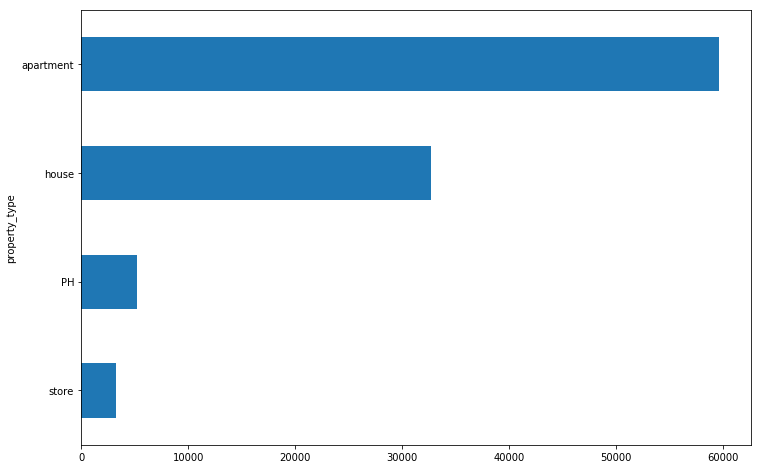

In [43]:
top_tipos.plot(kind='barh',figsize=TAM_IMG)
#plt.set_ylabel('Tipo')
#plt.set_xlabel('Cantidad')
plt.show()

## Promedio de precio por tipo

In [44]:
promedio_por_tipo = properati_filtrado.groupby('property_type')['precio_por_m2'].mean()

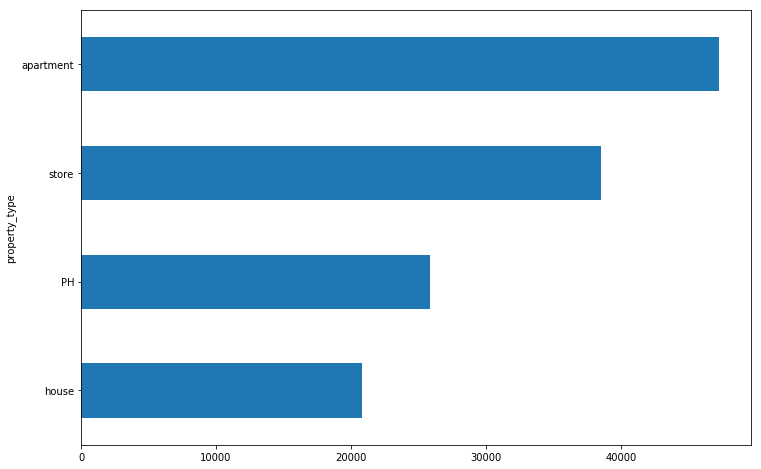

In [45]:
promedio_por_tipo.sort_values().plot(kind='barh',figsize=TAM_IMG)
#plt.set_ylabel('Tipo')
#plt.set_xlabel('Cantidad')
plt.show()

## Promedio precio por m2 por mes

In [46]:
promedio_por_tipo_y_mes = properati_filtrado.groupby(['property_type',properati_filtrado['created_on'].dt.month])['precio_por_m2'].mean().unstack(level=0)

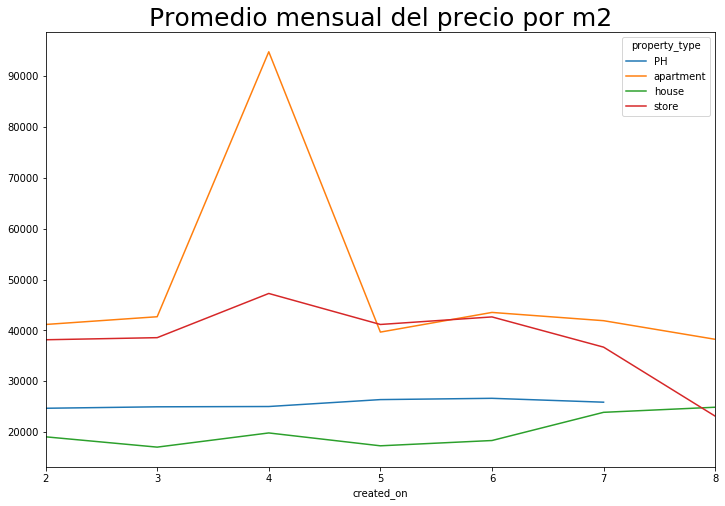

In [47]:
promedio_por_tipo_y_mes.plot(kind='line',figsize=TAM_IMG)
plt.title('Promedio mensual del precio por m2',size=25)
plt.show()

##  Valor de las expensas vs el precio total

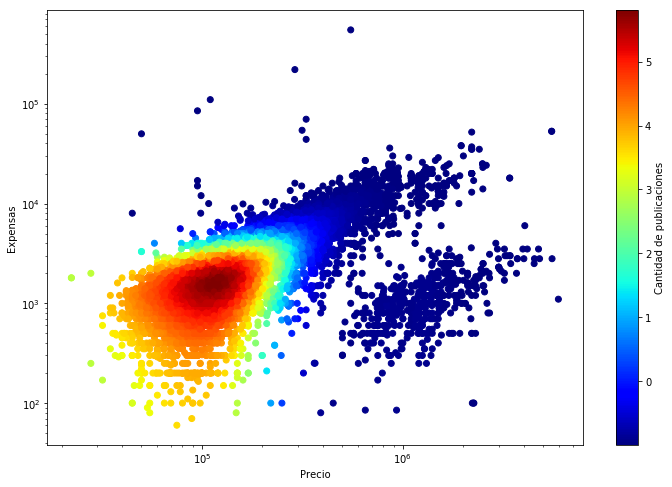

In [48]:
expensas_vs_precio = properati_filtrado.loc[(properati_filtrado['property_type'] == 'apartment') & (properati_filtrado.expenses<1000000) & (properati_filtrado.expenses>50)].loc[:,('price','expenses')].dropna() #hay unas expensas mal

cm = plt.cm.get_cmap('jet')

# Calculate the point density
from scipy.stats import gaussian_kde
xy = np.vstack([expensas_vs_precio['price'],expensas_vs_precio['expenses']])
z = gaussian_kde(xy)(xy)
plt.figure(figsize=TAM_IMG)

plt.scatter(expensas_vs_precio['price'],expensas_vs_precio['expenses'],c=z,cmap=cm)
cbr = plt.colorbar()
cbr.set_label('Cantidad de publicaciones')
cbr.ax.set_yticklabels(list(range(0,9)))

plt.xlabel('Precio')
plt.ylabel('Expensas')
plt.xscale('log')
plt.yscale('log')
plt.show()

##  Valor de las expensas vs el precio por m2

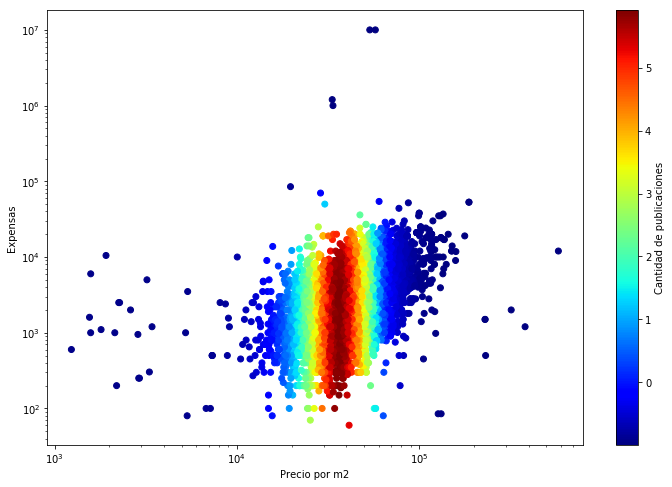

In [49]:
expensas_vs_precio = properati_filtrado.loc[(properati_filtrado['property_type'] == 'apartment') & (properati_filtrado.precio_por_m2>1000) & (properati_filtrado.expenses>50)].loc[:,('precio_por_m2','expenses')].dropna() #hay unas expensas mal

cm = plt.cm.get_cmap('jet')

# Calculate the point density
from scipy.stats import gaussian_kde
xy = np.vstack([expensas_vs_precio['precio_por_m2'],expensas_vs_precio['expenses']])
z = gaussian_kde(xy)(xy)
plt.figure(figsize=TAM_IMG)

plt.scatter(expensas_vs_precio['precio_por_m2'],expensas_vs_precio['expenses'],c=z,cmap=cm)
cbr = plt.colorbar()
cbr.set_label('Cantidad de publicaciones')
cbr.ax.set_yticklabels(list(range(0,9)))

plt.xlabel('Precio por m2')
plt.ylabel('Expensas')
plt.xscale('log')
plt.yscale('log')
plt.show()


##  Supeficie descubierta vs precio 

/home/ale/.local/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ale/.local/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


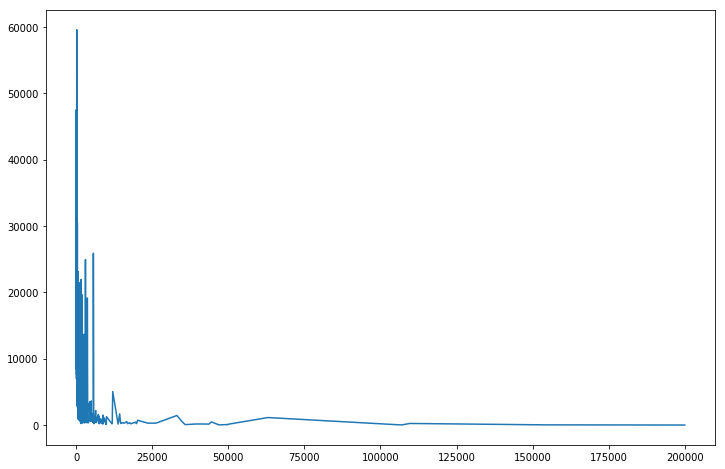

In [50]:
properati_filtrado.loc[:,'superficie_descubierta'] = properati_filtrado['surface_total_in_m2'] - properati_filtrado['surface_covered_in_m2']
properati_filtrado.loc[:,'superficie_descubierta'] = properati_filtrado.loc[properati_filtrado.superficie_descubierta>0 & ((properati_filtrado.property_type == "PH")|(properati_filtrado.property_type == "apartment"))]
precio_vs_descubierto= properati_filtrado.loc[:,('precio_por_m2','superficie_descubierta')].dropna()
precio_vs_descubierto = precio_vs_descubierto.groupby('superficie_descubierta').mean()

plt.figure(figsize=TAM_IMG)
plt.plot(precio_vs_descubierto)
plt.show()

##  Precio por m2 vs habitaciones

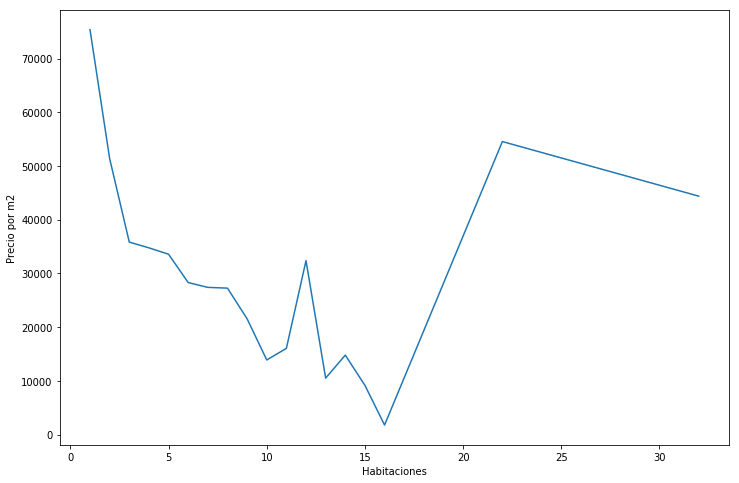

In [51]:
precio_vs_habs= properati_filtrado.loc[:,('precio_por_m2','rooms')].dropna()
precio_vs_habs= precio_vs_habs.groupby('rooms').mean()

plt.figure(figsize=TAM_IMG)
plt.xlabel('Habitaciones')
plt.ylabel('Precio por m2')
plt.plot(precio_vs_habs)
plt.show()

# <span style="color:red"> Poner nombre a ejes de graficos y refactorizar. Insertar columnas adicionales como a estrenar y con jardin en dataframe principal

## Metro cuadrado vs años para cada tipo

In [52]:
m2_anual = properati_filtrado.groupby(properati_filtrado.created_on.dt.year)
m2_anual = m2_anual.mean()['precio_por_m2']
m2_anual

created_on
2017    38145.371759
Name: precio_por_m2, dtype: float64

##  Piso del departamento vs precio

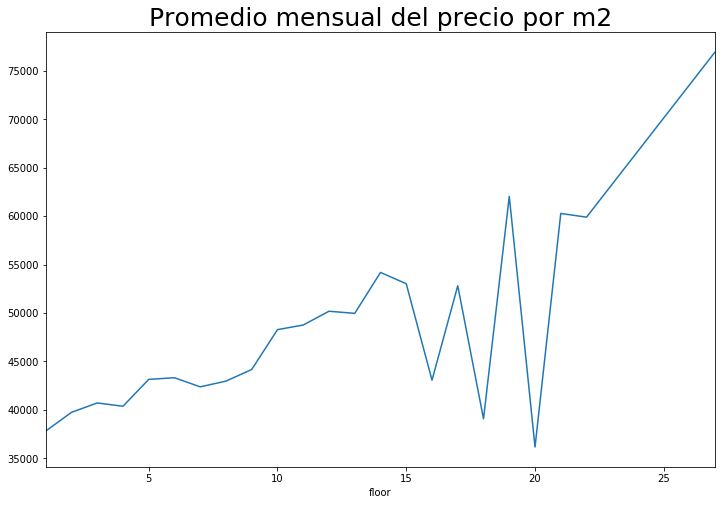

In [55]:
piso_vs_precio = properati_filtrado.loc[:,('precio_por_m2','floor')].dropna()
piso_vs_precio = piso_vs_precio.loc[piso_vs_precio.floor < 100]
piso_vs_precio = piso_vs_precio.groupby(properati_filtrado.floor)
piso_vs_precio = piso_vs_precio.mean()['precio_por_m2']
piso_vs_precio.plot(kind='line',figsize=TAM_IMG)
plt.title('Promedio mensual del precio por m2',size=25)
plt.show()

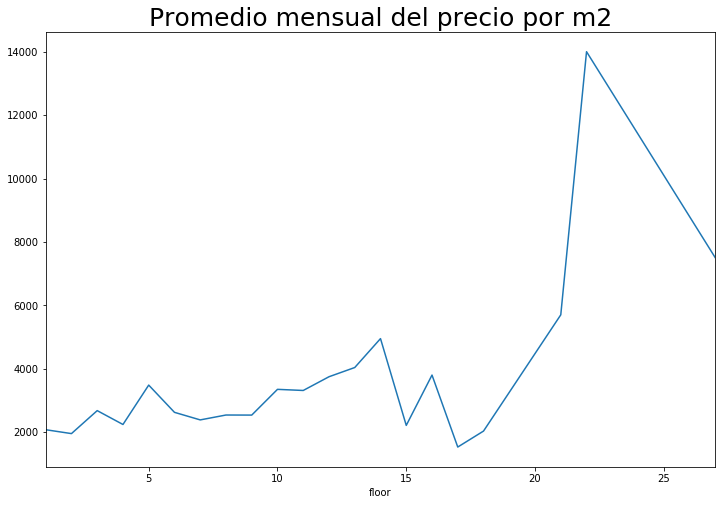

In [67]:
piso_vs_expensas = properati_filtrado.loc[:,('floor','expenses')].dropna(subset=['expenses'])
piso_vs_expensas = piso_vs_expensas.groupby(properati_filtrado.floor).mean()['expenses']
piso_vs_expensas.plot(kind='line',figsize=TAM_IMG)
plt.title('Promedio mensual del precio por m2',size=25)
plt.show()

## <span style="color:green"> Relacionar geonames en gmaps para graficar algunos resultados sobre regiones, zonas y demas